# Capstone 1 - EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import datetime
import seaborn as sns

In [2]:
# read in the data set, extract all the ticker symbols into a list
df = pd.read_csv('./data/all_cefs_clean.csv', parse_dates=['Date'], infer_datetime_format=True, index_col='ticker')
df.head()

,Date,Close,Adj_Close,NAV,Adj_NAV,Volume
ticker,,,,,,
ACP,2011-01-27,20.00,8.93,19.06,9.04,335449
ACP,2011-01-28,20.10,8.98,19.05,9.03,15700
ACP,2011-01-31,20.20,9.02,18.99,9.01,7400
ACP,2011-02-01,20.10,8.98,19.00,9.01,10150
ACP,2011-02-02,20.05,8.95,19.02,9.02,12050


In [3]:
# read in other fundamental fund data
fdf = pd.read_csv('./data/cef_fundem_clean.csv', index_col = 'Ticker')
fdf.head()

,Category,Mkt_Cap,Act_Exp,Net_Exp,Dist_Freq
Ticker,,,,,
ACP,Fixed Income,1.527958e+05,0.016755,0.023619,12.0
ACV,Equity US,2.230959e+05,0.010566,0.022416,12.0
ADX,Equity US,1.430408e+06,0.005337,0.005337,4.0
AEF,Equity Foreign,6.719044e+04,0.018305,0.020418,2.0
AFB,Municipal Bonds,3.695975e+05,0.006044,0.010214,12.0


In [4]:
# merge the pricing data with the fundamental data, set multi index to ticker(level 0) and Date(level 1)
df1 = df.merge(fdf, how='left', left_index=True, right_index=True)
df1.rename_axis('ticker', inplace=True)
df1.set_index(['Date'], append=True, inplace=True)

In [5]:
# drop the precious metals funds because there are only 4 of them
df1.query('Category != "Precious Metals"', inplace=True)

In [6]:
# Add the Discount column calculated as (Close-NAV)/NAV
df1['Discount'] = (df1.Close - df1.NAV) / df1.NAV

In [7]:
# drop the last date row for all funds because not all funds had that data
df1.drop(index=pd.datetime(2019,3,6), level=1, inplace=True)

In [8]:
# final ticker symbols for all funds
tickers = df1.index.get_level_values(0).unique()
tickers

Index(['ACP', 'ADX', 'AEF', 'AFB', 'AFT', 'AGD', 'AIF', 'AKP', 'AOD', 'APF',
       ...
       'VMO', 'VPV', 'VTA', 'VTN', 'VVR', 'WEA', 'WIA', 'WIW', 'ZF', 'ZTR'],
      dtype='object', name='ticker', length=445)

In [9]:
# function to annualize returns based on percent change and period (number of years)
def annualize(pchg, period):
    return (pchg + 1)**(1/period) - 1

In [64]:
# calculate 1, 3 , 5, and 10 year rolling returns
# shift the data back so that the returns are going forward
# calculate the Z-score for 1mo, 3mo, 6mo, 1yr, 2yr, 3yr
# calculate the 200 day moving average
ret_1 = []
ret_1past = []
ret_3 = []
ret_5 = []
ret_10 = []
ret_10past = []
Z1mo = []
Z3mo = []
Z6mo = []
Z1yr = []
Z2yr = []
Z3yr = []
ma200d = []
for t in tickers:
    ret_1.extend(df1.loc[t].Adj_Close.pct_change(252).shift(-252))
    ret_1past.extend(df1.loc[t].Adj_Close.pct_change(252))
    ret_3.extend(df1.loc[t].Adj_Close.pct_change(252*3).apply(annualize, args=(3,)).shift(-252*3))
    ret_5.extend(df1.loc[t].Adj_Close.pct_change(252*5).apply(annualize, args=(5,)).shift(-252*5))
    ret_10.extend(df1.loc[t].Adj_Close.pct_change(252*10).apply(annualize, args=(10,)).shift(-252*10))
    ret_10past.extend(df1.loc[t].Adj_Close.pct_change(252*10).apply(annualize, args=(10,)))
    Z1mo.extend((df1.loc[t, 'Discount'] - df1.loc[t, 'Discount'].rolling(21).mean()) / df1.loc[t, 'Discount'].rolling(21).std())
    Z3mo.extend((df1.loc[t, 'Discount'] - df1.loc[t, 'Discount'].rolling(21*3).mean()) / df1.loc[t, 'Discount'].rolling(21*3).std())
    Z6mo.extend((df1.loc[t, 'Discount'] - df1.loc[t, 'Discount'].rolling(21*6).mean()) / df1.loc[t, 'Discount'].rolling(21*6).std())
    Z1yr.extend((df1.loc[t, 'Discount'] - df1.loc[t, 'Discount'].rolling(252).mean()) / df1.loc[t, 'Discount'].rolling(252).std())
    Z2yr.extend((df1.loc[t, 'Discount'] - df1.loc[t, 'Discount'].rolling(252*2).mean()) / df1.loc[t, 'Discount'].rolling(252*2).std())
    Z3yr.extend((df1.loc[t, 'Discount'] - df1.loc[t, 'Discount'].rolling(252*3).mean()) / df1.loc[t, 'Discount'].rolling(252*3).std())
    ma200d.extend(df1.loc[t].Close.rolling(200).mean())
df1['ret_1'] = ret_1
df1['ret_1past'] = ret_1past
df1['ret_3'] = ret_3
df1['ret_5'] = ret_5
df1['ret_10'] = ret_10
df1['ret_10past'] = ret_10past
df1['Z1mo'] = Z1mo
df1['Z3mo'] = Z3mo
df1['Z6mo'] = Z6mo
df1['Z1yr'] = Z1yr
df1['Z2yr'] = Z2yr
df1['Z3yr'] = Z3yr
df1['ma200d'] = ma200d
df1.head()

Close  Adj_Close    NAV  Adj_NAV  Volume      Category  \
ticker Date                                                                 
ACP    2011-01-27  20.00       8.93  19.06     9.04  335449  Fixed Income   
       2011-01-28  20.10       8.98  19.05     9.03   15700  Fixed Income   
       2011-01-31  20.20       9.02  18.99     9.01    7400  Fixed Income   
       2011-02-01  20.10       8.98  19.00     9.01   10150  Fixed Income   
       2011-02-02  20.05       8.95  19.02     9.02   12050  Fixed Income   

                      Mkt_Cap   Act_Exp   Net_Exp  Dist_Freq     ...      \
ticker Date                                                      ...       
ACP    2011-01-27  152795.838  0.016755  0.023619       12.0     ...       
       2011-01-28  152795.838  0.016755  0.023619       12.0     ...       
       2011-01-31  152795.838  0.016755  0.023619       12.0     ...       
       2011-02-01  152795.838  0.016755  0.023619       12.0     ...       
       2011-02-02  152795.838  0.016755  0.023619       12.0     ...       

                   Z3mo  Z6mo  Z1yr  Z2yr  Z3yr  ma200d  from200d  ret1vcat  \
ticker Date                                                                   
ACP    2011-01-27   NaN   NaN   NaN   NaN   NaN     NaN       NaN -0.167345   
       2011-01-28   NaN   NaN   NaN   NaN   NaN     NaN       NaN -0.164342   
       2011-01-31   NaN   NaN   NaN   NaN   NaN     NaN       NaN -0.149245   
       2011-02-01   NaN   NaN   NaN   NaN   NaN     NaN       NaN -0.141881   
       2011-02-02   NaN   NaN   NaN   NaN   NaN     NaN       NaN -0.146390   

                   ret1vcatp  ret_10past  
ticker Date                               
ACP    2011-01-27        NaN         NaN  
       2011-01-28        NaN         NaN  
       2011-01-31        NaN         NaN  
       2011-02-01        NaN         NaN  
       2011-02-02        NaN         NaN  

[5 rows x 27 columns]

In [11]:
# calculate how far from the 200 day moving average in percentage
df1['from200d'] = (df1.Close - df1.ma200d) / df1.ma200d

In [79]:
# get the mean values by Category for each date
df2 = df1.groupby(['Date','Category']).mean()
df2.reset_index(level=1, inplace=True)
df2.head()

,Category,Close,Adj_Close,NAV,Adj_NAV,Volume,Mkt_Cap,Act_Exp,Net_Exp,Dist_Freq,...,Z3mo,Z6mo,Z1yr,Z2yr,Z3yr,ma200d,from200d,ret1vcat,ret1vcatp,ret_10past
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,Equity Foreign,17.998421,4.080526,28.267895,6.053684,134698.894737,216223.225405,0.014265,0.014378,2.052632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.427607e-17,NaN,NaN
2000-01-03,Equity US,17.815667,3.940000,20.179333,4.859667,78388.700000,602138.345850,0.012212,0.013898,5.766667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.405483e-17,NaN,NaN
2000-01-03,Fixed Income,9.994250,2.141000,11.731250,2.706500,161856.300000,347519.731045,0.009024,0.012716,10.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.775558e-18,NaN,NaN
2000-01-03,Municipal Bonds,11.267262,3.662619,12.288690,4.185000,34533.333333,359949.730360,0.006635,0.012561,12.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.608470e-17,NaN,NaN
2000-01-04,Equity Foreign,17.362105,3.984211,28.409474,6.090526,129886.684211,216223.225405,0.014265,0.014378,2.052632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.843279e-18,NaN,NaN


In [13]:
# calculate the 1yr return versus the mean category returns
ret1vcat = []
ret1vcatp = []
for t in tickers:
    categ = df1.loc[t].Category[0]
    ret1vcat.extend(df1.loc[t].ret_1 - df2.loc[df1.loc[t].index[0]:].query('Category == @categ').ret_1)
    ret1vcatp.extend(df1.loc[t].ret_1past - df2.loc[df1.loc[t].index[0]:].query('Category == @categ').ret_1past)
df1['ret1vcat'] = ret1vcat
df1['ret1vcatp'] = ret1vcatp

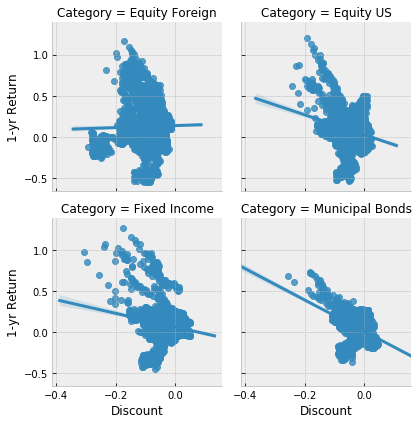

In [14]:
mpl.style.use('bmh')
g = sns.lmplot(x='Discount', y='ret_1', col='Category', col_wrap=2, height=3, data=df2)
g.set_axis_labels('Discount', '1-yr Return')

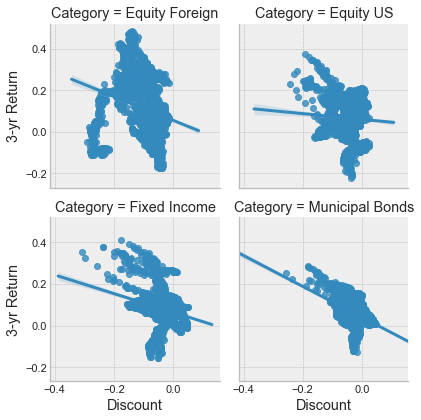

In [45]:

g = sns.lmplot(x='Discount', y='ret_3', col='Category', col_wrap=2, height=3, data=df2)
g.set_axis_labels('Discount', '3-yr Return')


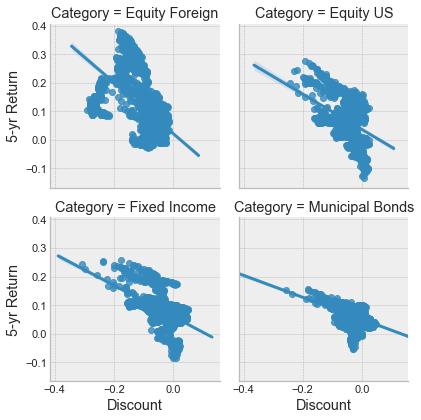

In [46]:

g = sns.lmplot(x='Discount', y='ret_5', col='Category', col_wrap=2, height=3, data=df2)
g.set_axis_labels('Discount', '5-yr Return')


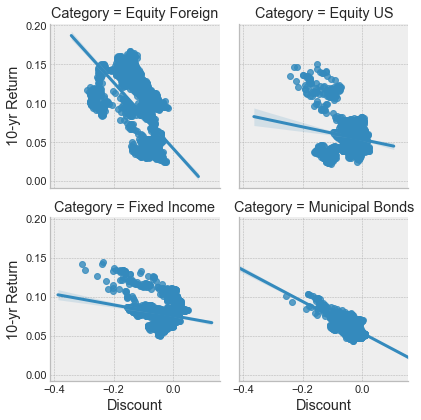

In [47]:

g = sns.lmplot(x='Discount', y='ret_10', col='Category', col_wrap=2, height=3, data=df2)
g.set_axis_labels('Discount', '10-yr Return')


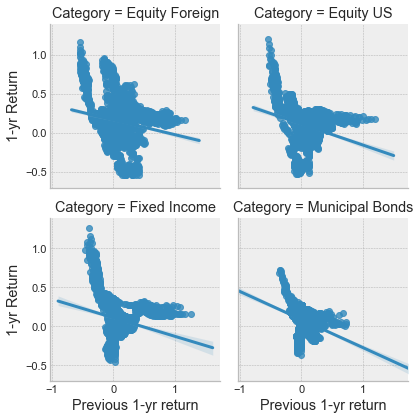

In [129]:
g = sns.lmplot(x='ret_1past', y='ret_1', col='Category', col_wrap=2, height=3, data=df2)
g.set_axis_labels('Previous 1-yr return', '1-yr Return')

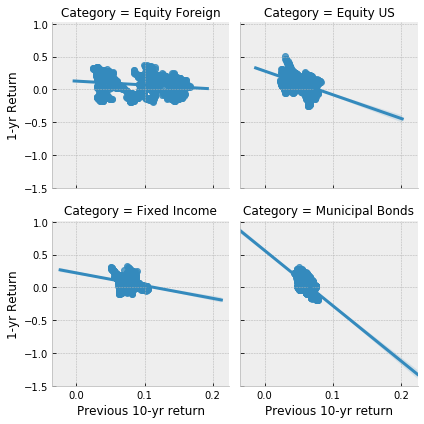

In [81]:
g = sns.lmplot(x='ret_10past', y='ret_1', col='Category', col_wrap=2, height=3, data=df2)
g.set_axis_labels('Previous 10-yr return', '1-yr Return')

In [ ]:
idx = pd.IndexSlice
data=df1.loc[idx[:, '2014-03-03':],]

In [67]:

for t in tickers:
    if (t == 'ACP'):
        dfbm = df1.loc[t].asfreq('BM')
    else:
        dfbm = dfbm.append(df1.loc[t].asfreq('BM'), sort=False)
dfbm                

,Close,Adj_Close,NAV,Adj_NAV,Volume,Category,Mkt_Cap,Act_Exp,Net_Exp,Dist_Freq,...,Z3mo,Z6mo,Z1yr,Z2yr,Z3yr,ma200d,from200d,ret1vcat,ret1vcatp,ret_10past
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-31,20.20,9.02,18.99,9.01,7400.0,Fixed Income,152795.838,0.016755,0.023619,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.149245,NaN,NaN
2011-02-28,20.00,8.93,19.13,9.07,10400.0,Fixed Income,152795.838,0.016755,0.023619,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.142230,NaN,NaN
2011-03-31,19.11,8.53,19.12,9.07,15485.0,Fixed Income,152795.838,0.016755,0.023619,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.141739,NaN,NaN
2011-04-29,19.50,8.77,19.36,9.24,25875.0,Fixed Income,152795.838,0.016755,0.023619,12.0,...,-0.748433,NaN,NaN,NaN,NaN,NaN,NaN,-0.135513,NaN,NaN
2011-05-31,19.75,8.94,19.23,9.24,46774.0,Fixed Income,152795.838,0.016755,0.023619,12.0,...,0.916047,NaN,NaN,NaN,NaN,NaN,NaN,-0.142344,NaN,NaN
2011-06-30,19.72,8.98,18.64,9.02,9658.0,Fixed Income,152795.838,0.016755,0.023619,12.0,...,1.581446,NaN,NaN,NaN,NaN,NaN,NaN,-0.154392,NaN,NaN
2011-07-29,18.70,8.58,18.65,9.09,47955.0,Fixed Income,152795.838,0.016755,0.023619,12.0,...,-1.629614,-1.213183,NaN,NaN,NaN,NaN,NaN,-0.157537,NaN,NaN
2011-08-31,16.93,7.82,16.98,8.34,42844.0,Fixed Income,152795.838,0.016755,0.023619,12.0,...,-0.794783,-0.774147,NaN,NaN,NaN,NaN,NaN,-0.079703,NaN,NaN
2011-09-30,15.50,7.22,15.71,7.78,24177.0,Fixed Income,152795.838,0.016755,0.023619,12.0,...,-0.254518,-0.662584,NaN,NaN,NaN,NaN,NaN,-0.017800,NaN,NaN


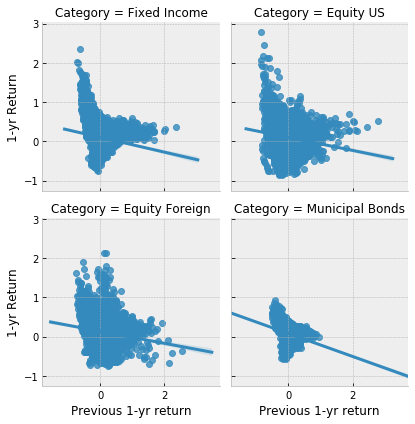

In [59]:
g = sns.lmplot(x='ret_1past', y='ret_1', col='Category', col_wrap=2, height=3, data=dfbm)
g.set_axis_labels('Previous 1-yr return', '1-yr Return')

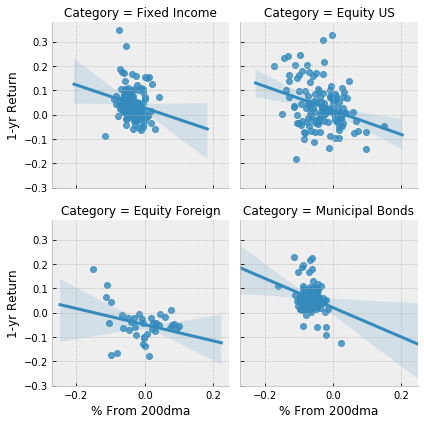

In [114]:
g = sns.lmplot(x='from200d', y='ret_1', col='Category', col_wrap=2, height=3, data=df1.loc[idx[:,'2018-03-02'],])
g.set_axis_labels('% From 200dma', '1-yr Return')

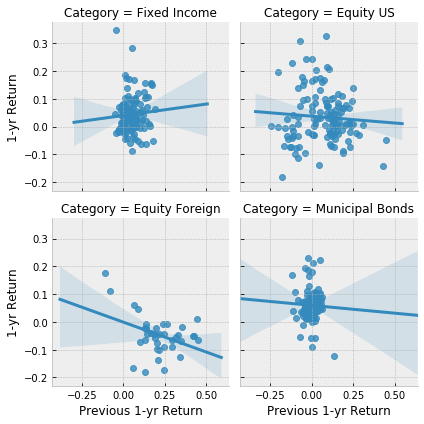

In [105]:
g = sns.lmplot(x='ret_1past', y='ret_1', col='Category', col_wrap=2, height=3, data=df1.loc[idx[:,'2018-03-02'],])
g.set_axis_labels('Previous 1-yr Return', '1-yr Return')

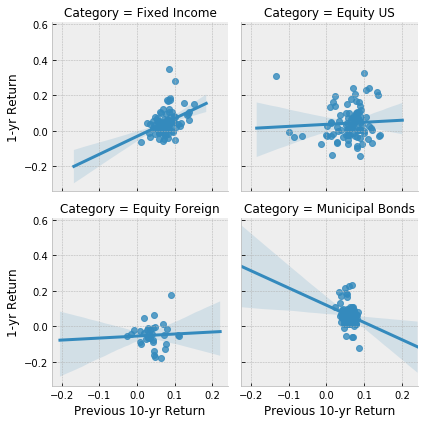

In [106]:
g = sns.lmplot(x='ret_10past', y='ret_1', col='Category', col_wrap=2, height=3, data=df1.loc[idx[:,'2018-03-02'],])
g.set_axis_labels('Previous 10-yr Return', '1-yr Return')


In [86]:
df2.groupby('Category').corr()[['ret_1', 'ret_3', 'ret_5', 'ret_10']]\
    .loc[(slice(None), ['Discount', 'Z1mo', 'Z6mo', 'Z1yr', 'Z3yr', 'from200d', 'ret_1past', 'ret_10past']),]

ret_1     ret_3     ret_5    ret_10
Category                                                          
Equity Foreign  Discount    0.026912 -0.260944 -0.583268 -0.626270
                Z1mo       -0.009258  0.058448  0.061053  0.083245
                Z1yr       -0.092755  0.106688  0.174018  0.255291
                Z3yr        0.059277  0.187321  0.066531  0.233491
                Z6mo       -0.076555  0.096241  0.154330  0.214901
                from200d   -0.172503 -0.099622 -0.252712 -0.166349
                ret_10past -0.189367 -0.442746 -0.138364       NaN
                ret_1past  -0.193101 -0.166389 -0.443761 -0.382965
Equity US       Discount   -0.235003 -0.061950 -0.404102 -0.176689
                Z1mo        0.011437  0.003956  0.070906 -0.140394
                Z1yr       -0.126023 -0.075072  0.001935 -0.540960
                Z3yr       -0.229484 -0.099603 -0.288714 -0.564032
                Z6mo       -0.045868 -0.038338  0.062632 -0.423845
                from200d   -0.249292 -0.298008 -0.451874 -0.696597
                ret_10past -0.426491 -0.898505 -0.414430       NaN
                ret_1past  -0.269126 -0.300664 -0.534178 -0.669599
Fixed Income    Discount   -0.208146 -0.289813 -0.545451 -0.221148
                Z1mo        0.026851  0.005593 -0.024363 -0.061415
                Z1yr        0.026878 -0.000050 -0.041805 -0.151847
                Z3yr       -0.008645 -0.040449 -0.205052 -0.232312
                Z6mo        0.027707 -0.003216 -0.026756 -0.125308
                from200d   -0.258322 -0.278154 -0.421557 -0.652141
                ret_10past -0.256250 -0.569632 -0.138002       NaN
                ret_1past  -0.237430 -0.208269 -0.447061 -0.596960
Municipal Bonds Discount   -0.496170 -0.479254 -0.444536 -0.607414
                Z1mo       -0.025908 -0.078964 -0.040266 -0.166259
                Z1yr       -0.224910 -0.312328 -0.164294 -0.574910
                Z3yr       -0.385885 -0.442012 -0.270793 -0.671695
                Z6mo       -0.166116 -0.221378 -0.091371 -0.448025
                from200d   -0.313032 -0.298507 -0.266310 -0.644687
                ret_10past -0.636653 -0.383123 -0.468737       NaN
                ret_1past  -0.361500 -0.317152 -0.310207 -0.572444

In [106]:
df1.groupby('ticker').mean().corr()

,Close,Adj_Close,NAV,Adj_NAV,Volume,Mkt_Cap,Act_Exp,Net_Exp,Dist_Freq,Discount,...,ret_10,Z1mo,Z3mo,Z6mo,Z1yr,Z2yr,Z3yr,ma200d,from200d,ret1vcat
Close,1.000000,0.683577,0.963440,0.653273,-0.140789,0.037423,0.119910,0.082778,-0.099503,0.121407,...,0.106725,-0.008227,-0.002638,0.023255,0.048415,0.085294,0.110632,0.999656,-0.117697,0.118319
Adj_Close,0.683577,1.000000,0.646995,0.975636,-0.201488,0.045080,0.116004,0.168073,-0.001523,-0.052090,...,0.120906,-0.350757,-0.270047,-0.172675,-0.096610,0.037324,0.162908,0.683534,-0.029257,0.042118
NAV,0.963440,0.646995,1.000000,0.661158,-0.133652,0.031864,0.120113,0.073407,-0.152644,-0.043936,...,0.153604,-0.056299,-0.035706,0.006287,0.038679,0.074927,0.106783,0.965649,-0.071993,0.134056
Adj_NAV,0.653273,0.975636,0.661158,1.000000,-0.194839,0.047014,0.130690,0.165057,-0.072127,-0.244441,...,0.131190,-0.411231,-0.321966,-0.219952,-0.140059,-0.012695,0.123090,0.654205,-0.003715,0.033149
Volume,-0.140789,-0.201488,-0.133652,-0.194839,1.000000,0.631524,0.003103,-0.033412,0.098327,0.005604,...,0.014272,-0.010679,-0.085473,-0.081762,-0.015729,0.061297,0.089714,-0.143791,-0.203289,0.016427
Mkt_Cap,0.037423,0.045080,0.031864,0.047014,0.631524,1.000000,-0.152206,-0.119907,0.111523,0.010231,...,0.131829,0.006319,-0.044810,-0.045886,0.025094,0.089089,0.124804,0.035313,0.096968,0.206190
Act_Exp,0.119910,0.116004,0.120113,0.130690,0.003103,-0.152206,1.000000,0.761749,-0.360344,-0.144967,...,-0.227555,-0.137321,-0.151358,-0.066703,-0.014239,0.007308,0.011356,0.115362,-0.375232,-0.208847
Net_Exp,0.082778,0.168073,0.073407,0.165057,-0.033412,-0.119907,0.761749,1.000000,-0.048241,-0.060262,...,-0.210677,-0.202131,-0.221283,-0.177934,-0.126331,-0.061445,-0.010068,0.080187,-0.305954,-0.105243
Dist_Freq,-0.099503,-0.001523,-0.152644,-0.072127,0.098327,0.111523,-0.360344,-0.048241,1.000000,0.303305,...,-0.042730,0.040547,-0.029491,-0.102754,-0.126743,-0.089762,0.003830,-0.101915,-0.014731,0.062226
Discount,0.121407,-0.052090,-0.043936,-0.244441,0.005604,0.010231,-0.144967,-0.060262,0.303305,1.000000,...,0.037456,0.332335,0.263871,0.218834,0.181766,0.143749,0.069328,0.120297,-0.060749,0.137268


In [144]:
df3 = df1.groupby(['ticker','Category']).mean()
df3.reset_index(level=1, inplace=True)
df3.head()

,Category,Close,Adj_Close,NAV,Adj_NAV,Volume,Mkt_Cap,Act_Exp,Net_Exp,Dist_Freq,...,Z3mo,Z6mo,Z1yr,Z2yr,Z3yr,ma200d,from200d,ret1vcat,ret_1past,ret1vcatp
ticker,,,,,,,,,,,,,,,,,,,,,
ACP,Fixed Income,15.380529,9.980049,16.436975,11.107745,64549.429902,152795.838,0.016755,0.023619,12.0,...,-0.011573,-0.085415,-0.161642,-0.338777,-0.305526,15.331628,-0.017295,0.004504,0.073292,0.004504
ADX,Equity US,13.246261,6.555265,15.332937,8.335124,122268.013877,1430408.160,0.005337,0.005337,4.0,...,0.046791,0.001319,-0.057945,-0.169707,-0.287216,13.000895,-0.009031,-0.022830,0.064664,-0.022830
AEF,Equity Foreign,12.515634,4.984103,13.295505,5.314122,38153.436413,67190.440,0.018305,0.020418,2.0,...,0.067022,0.130209,0.190985,0.234486,0.245768,12.675610,-0.002118,0.012296,0.138016,0.012296
AFB,Municipal Bonds,13.867127,8.827822,14.588484,9.520588,62635.326289,369597.461,0.006044,0.010214,12.0,...,0.032041,-0.024703,-0.051385,-0.097647,-0.006030,13.898177,-0.001824,0.003248,0.064515,0.003248
AFT,Fixed Income,17.295923,12.891603,18.265948,13.972885,73880.664028,229234.560,0.015318,0.023747,12.0,...,-0.139912,-0.054459,-0.134696,-0.425800,-0.481763,17.325789,-0.005676,-0.004610,0.063830,-0.004610


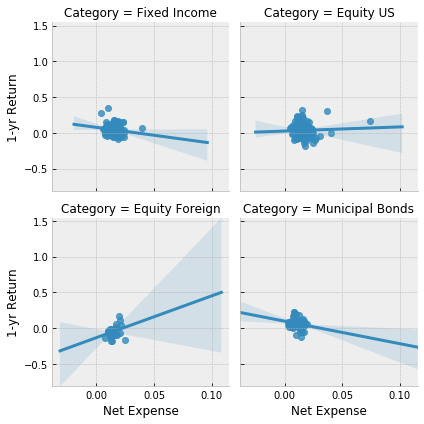

In [116]:
g = sns.lmplot(x='Net_Exp', y='ret_1', col='Category', col_wrap=2, height=3, data=df1.loc[idx[:,'2018-03-02'],])
g.set_axis_labels('Net Expense', '1-yr Return')
g.axes[0].autoscale(tight=True)

In [97]:
g.axes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F1EFEA2C50>,
      dtype=object)

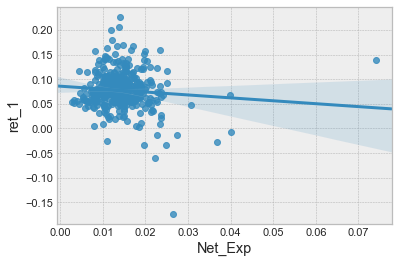

In [124]:
sns.regplot(x='Net_Exp', y='ret_1', data=df3)

In [125]:
df3[df3.Net_Exp > 0.03]

,Category,Close,Adj_Close,NAV,Adj_NAV,Volume,Mkt_Cap,Act_Exp,Net_Exp,Dist_Freq,...,ret_10,Z1mo,Z3mo,Z6mo,Z1yr,Z2yr,Z3yr,ma200d,from200d,ret1vcat
ticker,,,,,,,,,,,,,,,,,,,,,
BANX,Fixed Income,20.353172,16.759677,21.731436,18.171060,18195.195084,137839.9400,0.030399,0.039949,4.0,...,NaN,0.040830,0.098232,0.137364,0.328258,0.660966,0.843403,19.878020,-0.014541,0.009731
KMF,Equity US,23.289376,15.318694,24.873204,16.874664,114516.313160,256916.4400,0.020185,0.030609,12.0,...,NaN,-0.100364,-0.144535,-0.099439,-0.101809,-0.183541,-0.420514,23.826563,-0.029416,-0.037686
OXLC,Equity US,13.404805,6.655155,13.022450,5.893066,117697.941884,269571.8607,0.045817,0.074177,12.0,...,NaN,0.107935,0.064170,0.044220,0.124903,0.265646,0.257811,13.348018,-0.017773,0.051823
RCG,Equity US,5.652891,4.179822,6.883316,5.343940,9316.271748,7942.7952,0.036359,0.036868,1.0,...,-0.135693,0.008287,0.010672,-0.027306,-0.032747,-0.040686,-0.049153,5.599112,-0.038589,-0.115317
SRV,Equity US,35.908511,18.111210,32.795677,16.291320,27676.458118,68619.4600,0.032392,0.039987,12.0,...,-0.076267,-0.008093,0.044080,0.109583,0.112137,-0.099887,-0.414229,34.952715,-0.062437,-0.089479


Text(0.5, 1.0, 'NID fund Discount to 1-yr Return')

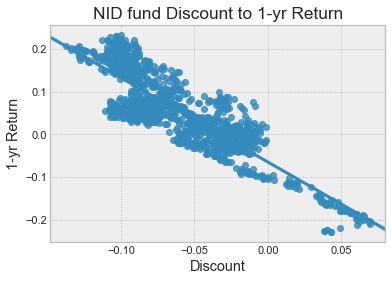

In [74]:
sns.regplot(x='Discount', y='ret_1', data=df1.loc['NID'])
plt.ylabel('1-yr Return')
plt.title('NID fund Discount to 1-yr Return')

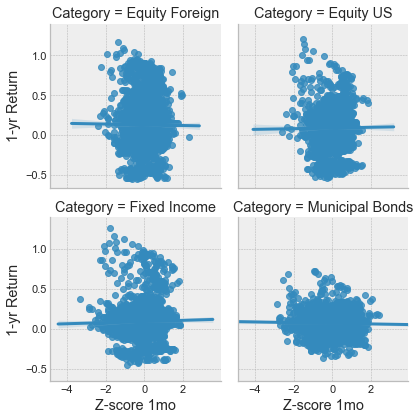

In [85]:

g = sns.lmplot(x='Z1mo', y='ret_1', col='Category', col_wrap=2, height=3, data=df2)
g.set_axis_labels('Z-score 1mo', '1-yr Return')


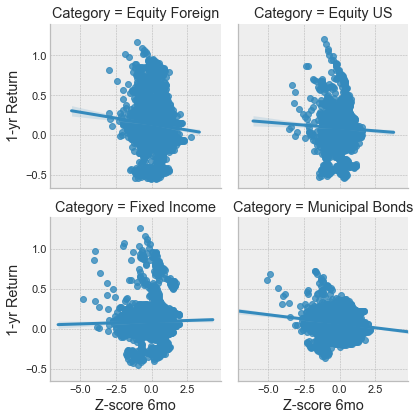

In [86]:

g = sns.lmplot(x='Z6mo', y='ret_1', col='Category', col_wrap=2, height=3, data=df2)
g.set_axis_labels('Z-score 6mo', '1-yr Return')


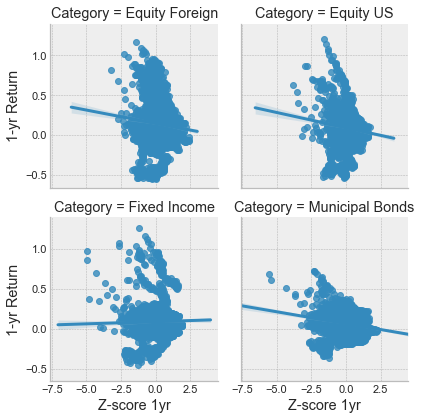

In [87]:

g = sns.lmplot(x='Z1yr', y='ret_1', col='Category', col_wrap=2, height=3, data=df2)
g.set_axis_labels('Z-score 1yr', '1-yr Return')


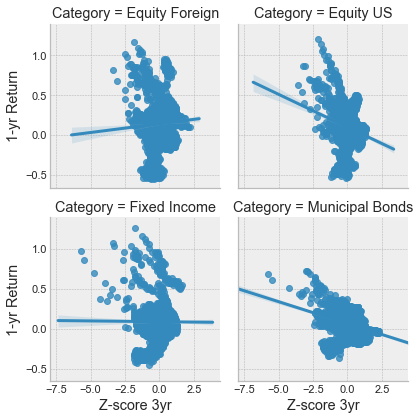

In [88]:

g = sns.lmplot(x='Z3yr', y='ret_1', col='Category', col_wrap=2, height=3, data=df2)
g.set_axis_labels('Z-score 3yr', '1-yr Return')


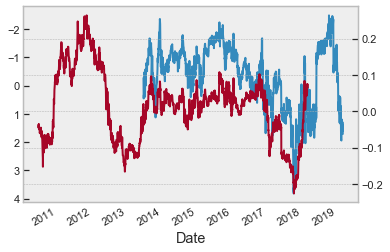

In [101]:
df1.loc['EXD'].Z3yr.plot()
plt.gca().invert_yaxis()
df1.loc['EXD'].ret_1.plot(secondary_y=True)


In [189]:
df1.loc[(slice(None), '2009-02-27'), ].nlargest(10,'ret_10')

,,Close,Adj_Close,NAV,Adj_NAV,Volume,Category,Mkt_Cap,Act_Exp,Net_Exp,Dist_Freq,...,ret_1,ret_3,ret_5,ret_10,Z1mo,Z3mo,Z6mo,Z1yr,Z2yr,Z3yr
ticker,Date,,,,,,,,,,,,,,,,,,,,,
RNP,2009-02-27,3.95,1.71,5.26,2.54,155342,Equity US,9.346916e+05,0.007695,0.012793,12.0,...,2.169591,0.759211,0.463233,0.277840,-1.313597,-0.042450,-0.525486,-1.231105,-1.890171,-2.367621
RQI,2009-02-27,2.42,1.07,2.79,1.35,179521,Equity US,1.337222e+06,0.009709,0.014637,12.0,...,1.925234,0.722666,0.456354,0.276592,0.327786,1.167289,0.079068,-0.668270,-0.935462,-0.975552
NRO,2009-02-27,1.24,0.56,1.45,0.71,239237,Equity US,2.271418e+05,0.009741,0.019493,12.0,...,1.964286,0.637755,0.403532,0.240440,-0.249176,0.375969,-0.197336,-0.836216,-1.249788,-0.782852
PTY,2009-02-27,7.49,2.16,6.69,1.62,658328,Fixed Income,1.354387e+06,0.005734,0.008178,12.0,...,1.560185,0.555532,0.381005,0.231073,-1.500395,-0.057629,0.368222,0.568343,0.910120,0.615549
JRS,2009-02-27,3.71,1.42,4.26,1.64,54044,Equity US,2.944095e+05,0.009444,0.015537,4.0,...,1.647887,0.631795,0.371867,0.219025,-1.211044,0.376043,0.401627,-0.277967,-0.892494,-1.217328
GGT,2009-02-27,3.03,1.20,4.11,1.71,37574,Equity US,2.017899e+05,0.011674,0.011694,4.0,...,1.200000,0.427408,0.407983,0.218804,-2.261461,-1.373187,-1.495855,-2.218171,-3.088436,-3.807832
HTD,2009-02-27,7.45,3.37,8.11,3.93,220063,Equity US,8.464092e+05,0.008186,0.014003,12.0,...,1.026706,0.466104,0.312384,0.218221,-0.200527,0.825439,1.125284,0.852705,1.132123,1.492502
DDF,2009-02-27,4.15,1.83,4.71,2.19,15934,Equity US,9.886768e+04,0.009094,0.015525,12.0,...,0.961749,0.374298,0.292856,0.214149,0.404002,0.553026,0.641850,0.024298,-0.389166,-0.700275
FFC,2009-02-27,6.55,2.70,7.01,2.83,161521,Fixed Income,8.226341e+05,0.005707,0.012608,12.0,...,1.622222,0.579523,0.359524,0.211364,-0.381318,0.517362,0.806138,0.695428,0.620430,0.659173


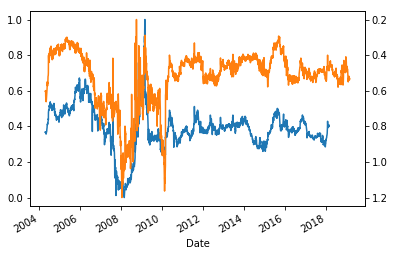

In [17]:
normret = (df1.loc['ERH'].ret_1 - df1.loc['ERH'].ret_1.min()) / (df1.loc['ERH'].ret_1.max() - df1.loc['ERH'].ret_1.min())
normret.plot()
normdisc = (df1.loc['ERH'].Discount - df1.loc['ERH'].Discount.min()) / (df1.loc['ERH'].Discount.max() - df1.loc['ERH'].Discount.min())
normdisc = normdisc + 0.2
normdisc.plot(secondary_y=True)
plt.gca().invert_yaxis()
# df2.query('Category == "Equity Foreign"').ret_1.plot()

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [69]:
X = np.array(df1.loc['BANX'].Discount.iloc[:-252]).reshape(-1, 1)
y = df1.loc['BANX'].ret_1.iloc[:-252]
reg = LinearRegression().fit(X,y)
yhat = reg.predict(np.array(df1.loc['BANX'].Discount).reshape(-1,1))
yhat = pd.Series(yhat, index=df1.loc['BANX'].Discount.index)

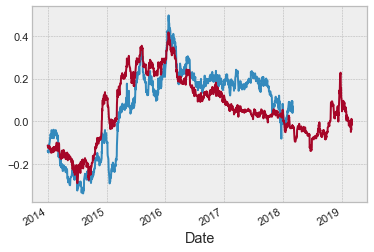

In [70]:
y.plot()
yhat.plot()

In [71]:
reg.score(X, y)

0.6981912473396579

In [363]:
clf = Lasso()
clf.fit(X, y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [366]:
ylasso = clf.predict(np.array(df1.loc['ERH'].Discount).reshape(-1,1))
ylasso = pd.Series(ylasso, index=df1.loc['ERH'].Discount.index)

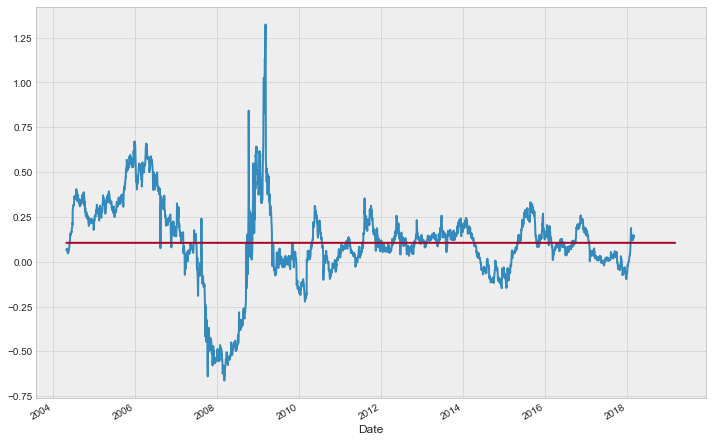

In [367]:
y.plot()
ylasso.plot()

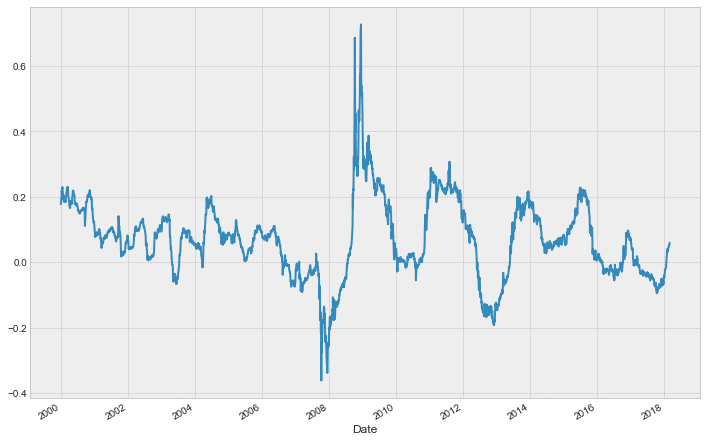

In [304]:
df2.query('Category == "Municipal Bonds"').ret_1.plot()

In [78]:
df1.loc['NID'].corr().loc['Discount'][['ret_1', 'ret_3', 'ret_5', 'ret_10', 'ret1vcat']]

ret_1      -0.870679
ret_3      -0.646807
ret_5      -0.937441
ret_10           NaN
ret1vcat   -0.136797
Name: Discount, dtype: float64

In [87]:
disc_corr=[]
Z3yr_corr=[]
ret10p_corr = []
for t in tickers:
    disc_corr.append(list(df1.loc[t].corr().loc['Discount'][['ret_1', 'ret_3', 'ret_5', 'ret_10', 'ret1vcat']]))
    Z3yr_corr.append(list(df1.loc[t].corr().loc['Z3yr'][['ret_1', 'ret_3', 'ret_5', 'ret_10', 'ret1vcat']]))
    ret10p_corr.append(list(df1.loc[t].corr().loc['ret_10past'][['ret_1', 'ret_3', 'ret_5', 'ret_10', 'ret1vcat']]))
corrdf = pd.DataFrame(disc_corr, index = tickers, columns = ['ret1', 'ret3', 'ret5', 'ret10', 'ret1vcat'])
Z3yr_corrdf = pd.DataFrame(Z3yr_corr, index = tickers, columns = ['ret1', 'ret3', 'ret5', 'ret10', 'ret1vcat'])
ret10p_corrdf = pd.DataFrame(ret10p_corr, index = tickers, columns = ['ret1', 'ret3', 'ret5', 'ret10', 'ret1vcat'])

In [89]:
ret10p_corrdf.mean(axis=1).nsmallest(5)

ticker
KYN    -0.873932
DEX    -0.873678
SRV    -0.852415
CHW    -0.843930
QQQX   -0.842760
dtype: float64

In [92]:
corrdf.mean(axis=1).nsmallest(5)

ticker
AWP   -0.718075
MCN   -0.717115
DEX   -0.712084
JDD   -0.708792
MIY   -0.704355
dtype: float64

In [93]:
Z3yr_corrdf.mean(axis=1).nsmallest(5)

ticker
RGT   -0.758402
AIF   -0.738325
FEI   -0.711303
ERH   -0.705073
NBB   -0.700544
dtype: float64

In [81]:
corrdf.nsmallest(5, 'ret1vcat')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
AOD,-0.425117,-0.702978,-0.510203,-0.493297,-0.879788
VGI,-0.646176,-0.554902,0.391346,NaN,-0.793456
DFP,-0.593974,-0.449662,-0.639775,NaN,-0.787038
BTT,-0.712985,-0.300167,-0.714306,NaN,-0.786817
AGD,-0.279355,-0.531941,-0.263265,0.000489,-0.765065


In [94]:
Z3yr_corrdf.nsmallest(5, 'ret1vcat')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
NBB,-0.537498,-0.780183,-0.616027,NaN,-0.868469
BBN,-0.596973,-0.618078,-0.105213,NaN,-0.851785
GBAB,-0.635503,-0.686730,-0.245205,NaN,-0.829004
IGI,-0.450982,-0.848118,-0.437057,NaN,-0.816960
FEI,-0.657176,-0.674666,NaN,NaN,-0.802066


In [91]:
ret10p_corrdf.nlargest(5, 'ret1vcat')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
BGY,-0.733744,NaN,NaN,NaN,0.788214
FGB,0.385954,NaN,NaN,NaN,0.762145
GRX,-0.271546,NaN,NaN,NaN,0.606596
RIF,0.275595,-0.760783,0.653377,NaN,0.535934
HNW,-0.231526,NaN,NaN,NaN,0.532686


In [80]:
corrdf.nsmallest(5, 'ret1')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
NID,-0.870679,-0.646807,-0.937441,NaN,-0.136797
BANX,-0.835578,-0.976332,-0.246830,NaN,-0.695605
NIQ,-0.823652,-0.541919,-0.958728,NaN,-0.138873
RGT,-0.776821,-0.629440,-0.429398,NaN,-0.634399
MMD,-0.755957,-0.652662,-0.735361,NaN,-0.226609


In [95]:
Z3yr_corrdf.nsmallest(5, 'ret1')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
RGT,-0.888082,NaN,NaN,NaN,-0.628723
ARDC,-0.879461,-0.187230,NaN,NaN,-0.662568
JRI,-0.812799,-0.851059,NaN,NaN,-0.407776
MMD,-0.801543,-0.853437,NaN,NaN,0.283621
EXD,-0.799058,0.243418,-0.811457,NaN,-0.343730


In [181]:
corrdf.nsmallest(5, 'ret3')

,ret1,ret3,ret5,ret10
ticker,,,,
BANX,-0.835578,-0.976332,-0.246830,NaN
ARDC,-0.492868,-0.968813,0.013487,NaN
BGB,-0.353916,-0.949338,-0.516526,NaN
EFF,-0.448739,-0.947568,-0.319108,NaN
AIF,-0.398822,-0.932549,-0.645761,NaN


In [96]:
Z3yr_corrdf.nsmallest(5, 'ret3')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
AIF,-0.635451,-0.985077,NaN,NaN,-0.594448
EOT,-0.620354,-0.924961,-0.690513,NaN,0.294166
DBL,-0.423369,-0.915470,NaN,NaN,-0.678342
OXLC,-0.263309,-0.891564,NaN,NaN,-0.261423
NUW,-0.587397,-0.865336,-0.437937,NaN,-0.328117


In [182]:
corrdf.nsmallest(5, 'ret5')

,ret1,ret3,ret5,ret10
ticker,,,,
NIQ,-0.823652,-0.541919,-0.958728,NaN
NID,-0.870679,-0.646807,-0.937441,NaN
DMB,-0.678205,-0.139566,-0.928645,NaN
BFO,-0.365465,-0.561149,-0.901806,-0.587199
MCN,-0.410675,-0.793054,-0.886538,-0.894982


In [97]:
Z3yr_corrdf.nsmallest(5, 'ret5')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
JMT,0.195560,-0.611020,-0.963632,NaN,-0.020561
GNT,-0.263559,-0.781086,-0.942959,NaN,-0.539407
JLS,0.055248,-0.721341,-0.929221,NaN,-0.091410
ERH,-0.604986,-0.808055,-0.839217,-0.910597,-0.362512
BKT,-0.485311,-0.631504,-0.822131,-0.780791,-0.274043


In [183]:
corrdf.nsmallest(5, 'ret10')

,ret1,ret3,ret5,ret10
ticker,,,,
DEX,-0.489417,-0.656300,-0.803615,-0.922793
RIF,-0.587472,-0.492344,-0.753376,-0.919175
IAF,-0.282653,-0.700695,-0.811442,-0.917128
EXG,-0.535225,-0.637158,-0.641693,-0.915715
BXMX,-0.348298,-0.612903,-0.743888,-0.904450


In [98]:
Z3yr_corrdf.nsmallest(5, 'ret10')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
EGF,-0.280565,-0.106190,-0.327134,-0.927543,-0.251851
ERH,-0.604986,-0.808055,-0.839217,-0.910597,-0.362512
CII,-0.586024,-0.655400,-0.655527,-0.854721,-0.169368
BIF,-0.201295,-0.606812,-0.756983,-0.853700,0.269470
JTA,-0.231116,-0.256649,-0.419841,-0.840690,-0.106201


Text(0.5, 1.0, '1-yr return vs. discount')

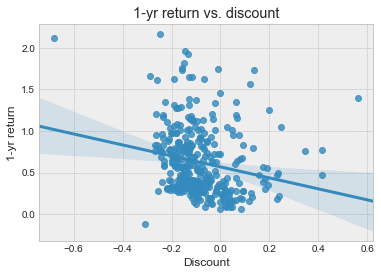

In [57]:
# sns.set_style(style='darkgrid')
mpl.style.use('bmh')
sns.regplot(x='Discount', y='ret_1', data=df1.loc[(slice(None), '2009-02-27'),])
plt.ylabel('1-yr return')
plt.title('1-yr return vs. discount')

In [75]:
df1.loc[(slice(None), '2018-03-01'),].ret_1.max()

0.35240963855421703

Text(0.5, 1.0, '10-yr return vs. Net Expense')

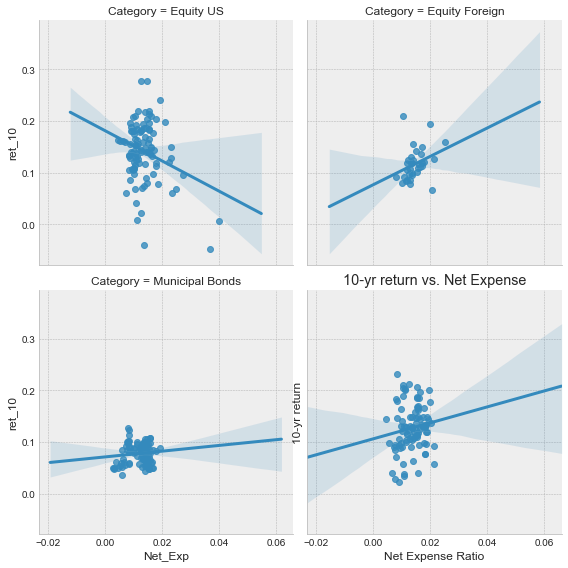

In [147]:
# sns.set_style(style='darkgrid')

sns.lmplot(x='Net_Exp', y='ret_10', col='Category', col_wrap=2, height=4, data=df1.loc[(slice(None), '2009-02-27'),])
plt.ylabel('10-yr return')
plt.xlabel('Net Expense Ratio')
plt.title('10-yr return vs. Net Expense')

Text(0.5, 1.0, '1-yr return vs. Z-score 1 mo')

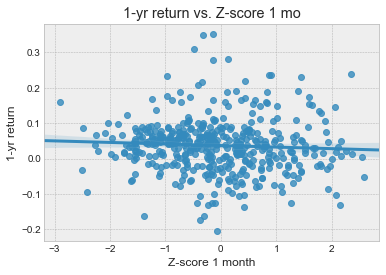

In [31]:
sns.regplot(x='Z1mo', y='ret_1', data=df1.loc[(slice(None), '2018-03-01'),])
plt.ylabel('1-yr return')
plt.xlabel('Z-score 1 month')
plt.title('1-yr return vs. Z-score 1 mo')

Text(0.5, 1.0, '1-yr return vs. Z-score 3 mo')

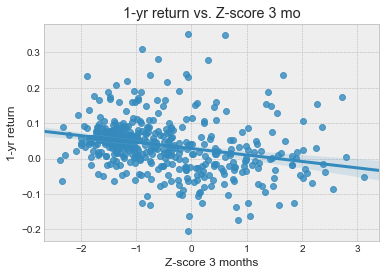

In [32]:
sns.regplot(x='Z3mo', y='ret_1', data=df1.loc[(slice(None), '2018-03-01'),])
plt.ylabel('1-yr return')
plt.xlabel('Z-score 3 months')
plt.title('1-yr return vs. Z-score 3 mo')

Text(0.5, 1.0, '1-yr return vs. Z-score 6 mo')

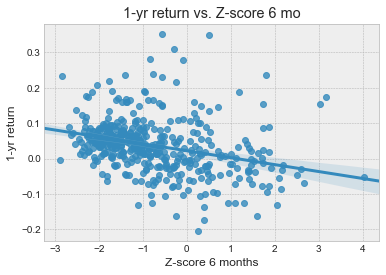

In [33]:
sns.regplot(x='Z6mo', y='ret_1', data=df1.loc[(slice(None), '2018-03-01'),])
plt.ylabel('1-yr return')
plt.xlabel('Z-score 6 months')
plt.title('1-yr return vs. Z-score 6 mo')

Text(0.5, 1.0, '1-yr return vs. Z-score 1 yr')

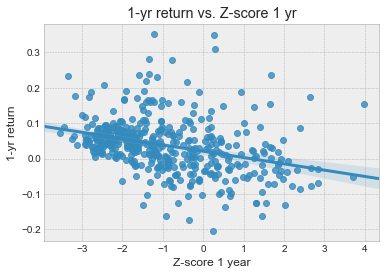

In [35]:
sns.regplot(x='Z1yr', y='ret_1', data=df1.loc[(slice(None), '2018-03-01'),])
plt.ylabel('1-yr return')
plt.xlabel('Z-score 1 year')
plt.title('1-yr return vs. Z-score 1 yr')

Text(0.5, 1.0, '1-yr return vs. Z-score 2 yr')

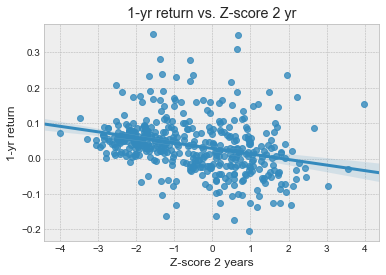

In [36]:
sns.regplot(x='Z2yr', y='ret_1', data=df1.loc[(slice(None), '2018-03-01'),])
plt.ylabel('1-yr return')
plt.xlabel('Z-score 2 years')
plt.title('1-yr return vs. Z-score 2 yr')

Text(0.5, 1.0, '1-yr return vs. Z-score 3 yr')

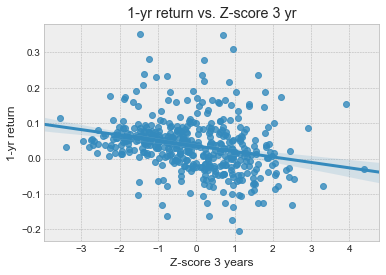

In [37]:
sns.regplot(x='Z3yr', y='ret_1', data=df1.loc[(slice(None), '2018-03-01'),])
plt.ylabel('1-yr return')
plt.xlabel('Z-score 3 years')
plt.title('1-yr return vs. Z-score 3 yr')

In [50]:
df1.loc[(slice(None), '2011-03-01'),].corr()

,Close,Adj_Close,NAV,Adj_NAV,Volume,Mkt_Cap,Act_Exp,Net_Exp,Dist_Freq,Discount,ret_1,ret_3,ret_5,ret_10,Z1mo,Z3mo,Z6mo,Z1yr,Z2yr,Z3yr
Close,1.000000,0.843487,0.957455,0.782186,-0.090827,0.005942,0.201422,0.119912,-0.198471,0.204438,-0.274331,-0.163141,-0.310790,NaN,-0.010646,-0.071959,-0.011450,0.071064,0.039851,0.021619
Adj_Close,0.843487,1.000000,0.856720,0.955247,-0.033870,0.019974,0.067682,0.026811,-0.178248,0.042740,-0.118507,-0.287580,-0.277303,NaN,-0.093418,-0.136865,-0.051202,0.037120,0.021359,-0.008152
NAV,0.957455,0.856720,1.000000,0.873329,-0.106345,0.006593,0.208879,0.111524,-0.271780,-0.057473,-0.265971,-0.120219,-0.267001,NaN,-0.090897,-0.165950,-0.081583,0.036979,0.026578,-0.018240
Adj_NAV,0.782186,0.955247,0.873329,1.000000,-0.065511,0.015141,0.088511,0.018572,-0.262218,-0.214694,-0.146521,-0.241591,-0.240672,NaN,-0.164422,-0.218411,-0.123377,0.001693,0.008503,-0.048925
Volume,-0.090827,-0.033870,-0.106345,-0.065511,1.000000,0.547227,-0.086046,-0.180238,0.100610,0.050722,-0.225670,-0.150624,-0.244309,NaN,0.154863,0.118112,0.113581,0.051571,-0.048104,-0.046543
Mkt_Cap,0.005942,0.019974,0.006593,0.015141,0.547227,1.000000,-0.171047,-0.187097,0.098563,-0.001617,-0.002383,0.108111,0.058448,NaN,0.042673,0.059247,0.059657,0.026813,-0.034061,-0.053771
Act_Exp,0.201422,0.067682,0.208879,0.088511,-0.086046,-0.171047,1.000000,0.680072,-0.425648,-0.114910,-0.463652,-0.028253,-0.381803,NaN,-0.005196,-0.059410,0.035963,0.083884,0.091988,0.064383
Net_Exp,0.119912,0.026811,0.111524,0.018572,-0.180238,-0.187097,0.680072,1.000000,-0.058227,-0.046209,-0.103992,0.004563,-0.190369,NaN,-0.049717,-0.046779,0.010207,0.015211,0.148391,0.189237
Dist_Freq,-0.198471,-0.178248,-0.271780,-0.262218,0.100610,0.098563,-0.425648,-0.058227,1.000000,0.246887,0.426171,-0.039829,0.233221,NaN,-0.052917,-0.009337,-0.128654,-0.272331,-0.210639,-0.096909
Discount,0.204438,0.042740,-0.057473,-0.214694,0.050722,-0.001617,-0.114910,-0.046209,0.246887,1.000000,-0.030159,-0.187907,-0.141293,NaN,0.316376,0.374872,0.314504,0.215749,0.135255,0.224667


C:\Users\robin\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\robin\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  52.,  242., 1234., 1221.,  980.,  227.,   70.,   33.,   10.,
           4.]),
 array([-3.68305082, -2.63457423, -1.58609763, -0.53762104,  0.51085555,
         1.55933215,  2.60780874,  3.65628534,  4.70476193,  5.75323852,
         6.80171512]),
 <a list of 10 Patch objects>)

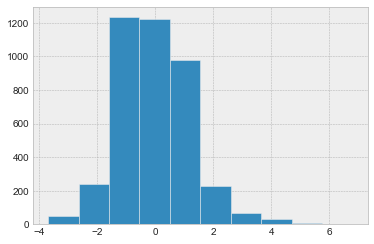

In [48]:
plt.hist(df1.loc['IIF', 'Z3yr'])

In [197]:
import statsmodels.api as sm
from pylab import rcParams

In [216]:
df3 = df1.loc['IIF'].Adj_Close
df3.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01',
               '2019-03-04', '2019-03-05'],
              dtype='datetime64[ns]', name='Date', length=4828, freq=None)

In [301]:
df2.query('Category == "Municipal Bonds"').ret_1.iloc[:-252]

Date
2000-01-03    0.177690
2000-01-04    0.183810
2000-01-05    0.185786
2000-01-06    0.186723
2000-01-07    0.196460
2000-01-10    0.200645
2000-01-11    0.212986
2000-01-12    0.218288
2000-01-13    0.213976
2000-01-14    0.222030
2000-01-18    0.229174
2000-01-19    0.226673
2000-01-20    0.228497
2000-01-21    0.221188
2000-01-24    0.217359
2000-01-25    0.206425
2000-01-26    0.201828
2000-01-27    0.194036
2000-01-28    0.196858
2000-01-31    0.200276
2000-02-01    0.205237
2000-02-02    0.198640
2000-02-03    0.186739
2000-02-04    0.184865
2000-02-07    0.186408
2000-02-08    0.186270
2000-02-09    0.188370
2000-02-10    0.189899
2000-02-11    0.191342
2000-02-14    0.194894
                ...   
2018-01-22   -0.014399
2018-01-23   -0.010523
2018-01-24   -0.008557
2018-01-25   -0.005447
2018-01-26    0.000462
2018-01-29    0.014833
2018-01-30    0.023427
2018-01-31    0.024466
2018-02-01    0.026158
2018-02-02    0.033080
2018-02-05    0.040354
2018-02-06    0.035379
2018-0

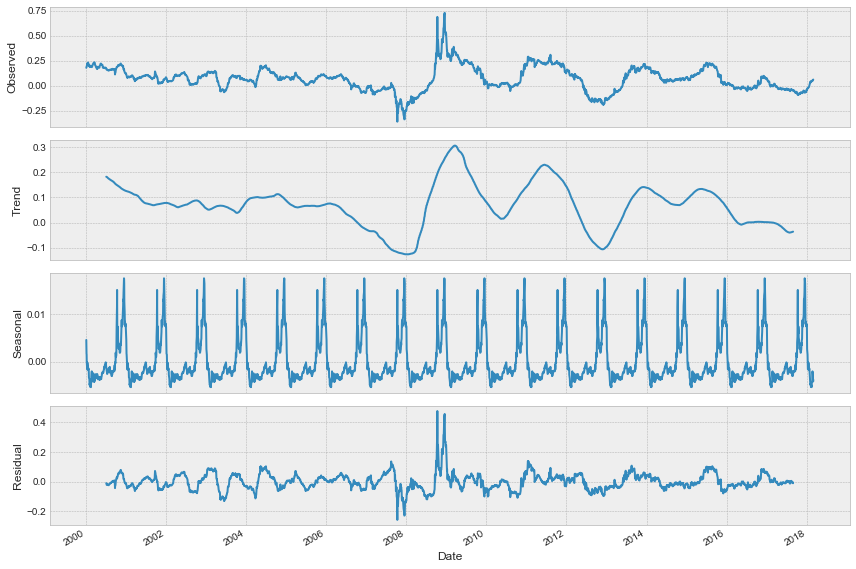

In [302]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(df2.query('Category == "Municipal Bonds"').ret_1.iloc[:-252], model='additive', freq=252)
fig = decomposition.plot()
plt.show()

In [ ]:
df1.head()